In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    recall_score,
    f1_score
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [3]:

df = pd.read_csv('../Data/data_standardized.csv')

In [4]:
print(f"Shape: {df.shape}")
print("\nPremières lignes:")
print(df.head())

Shape: (255347, 10)

Premières lignes:
   Unnamed: 0       Age    Income  LoanAmount  MonthsEmployed  InterestRate  \
0           0  0.833990  0.089693   -1.086833        0.590533      0.261771   
1           1  1.701221 -0.823021   -0.044309       -1.285731     -1.308350   
2           2  0.166888  0.043854    0.022715       -0.968209      1.156831   
3           3 -0.767053 -1.303452   -1.168538       -1.718715     -0.967805   
4           4  1.100830 -1.592855   -1.671921       -1.487790     -1.052188   

   Risk_Score  Affordability_Index  Employment_Maturity  Default  
0   -0.205494             0.360521             0.789675        0  
1   -0.072441            -0.454419            -0.420416        0  
2    0.127186            -0.386242            -0.301056        1  
3    2.604539            -0.492552            -6.157480        0  
4    0.222707            -0.380341            -1.054394        0  


In [5]:
print("\nInfo sur les colonnes:")
print(df.info())


Info sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           255347 non-null  int64  
 1   Age                  255347 non-null  float64
 2   Income               255347 non-null  float64
 3   LoanAmount           255347 non-null  float64
 4   MonthsEmployed       255347 non-null  float64
 5   InterestRate         255347 non-null  float64
 6   Risk_Score           255347 non-null  float64
 7   Affordability_Index  255347 non-null  float64
 8   Employment_Maturity  255347 non-null  float64
 9   Default              255347 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 19.5 MB
None


In [6]:
print("Distribution de Default:")
print(df['Default'].value_counts())
print("\nPourcentages:")
print(df['Default'].value_counts(normalize=True) * 100)

Distribution de Default:
Default
0    225694
1     29653
Name: count, dtype: int64

Pourcentages:
Default
0    88.387175
1    11.612825
Name: proportion, dtype: float64


In [7]:
X = df.drop('Default', axis=1)
y = df['Default']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")

X shape: (255347, 9)
y shape: (255347,)

Features: ['Unnamed: 0', 'Age', 'Income', 'LoanAmount', 'MonthsEmployed', 'InterestRate', 'Risk_Score', 'Affordability_Index', 'Employment_Maturity']


In [8]:
# Split train/test (stratifié pour garder le ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
#random_state=42 (ou n'importe quel nombre), je garantis que le split training/test reste toujours identique à chaque fois que je relances le code.
#stratify=y → on garde la même proportion de classes dans train et test pour ne pas biaiser la validation.
print(f"\nTrain: {X_train.shape[0]} exemples")
print(f"Test: {X_test.shape[0]} exemples")


Train: 204277 exemples
Test: 51070 exemples


*** Sans Reequilibrage ***

In [9]:
def evaluate_model(y_true, y_pred, y_proba, name):
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    print(f"\n📊 Résultats pour {name}")
    print(classification_report(y_true, y_pred, digits=3))
    print(f"🔹 Recall: {recall:.3f}")
    print(f"🔹 F1-Score: {f1:.3f}")
    print(f"🔹 AUC-ROC: {auc:.3f}")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()

    return recall, f1, auc


=== OPTION 0 : Sans équilibrage ===

📊 Résultats pour Decision Tree Sans Équilibrage
              precision    recall  f1-score   support

           0      0.886     0.998     0.939     45139
           1      0.626     0.022     0.042      5931

    accuracy                          0.885     51070
   macro avg      0.756     0.510     0.490     51070
weighted avg      0.856     0.885     0.835     51070

🔹 Recall: 0.022
🔹 F1-Score: 0.042
🔹 AUC-ROC: 0.716


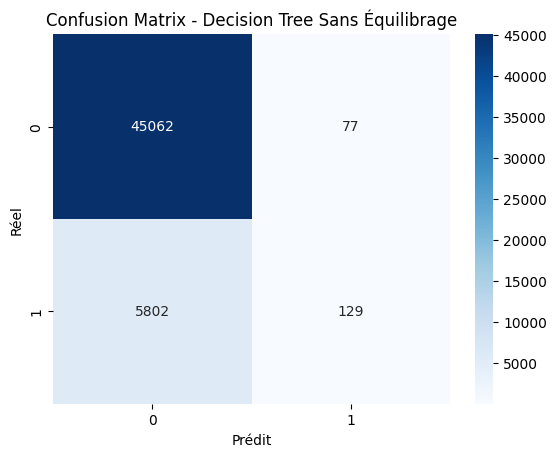

In [12]:
print("\n=== OPTION 0 : Sans équilibrage ===")
dt_base = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_base.fit(X_train, y_train)
y_pred_base = dt_base.predict(X_test)
y_proba_base = dt_base.predict_proba(X_test)[:, 1]

rec_base, f1_base, auc_base = evaluate_model(y_test, y_pred_base, y_proba_base, "Decision Tree Sans Équilibrage")

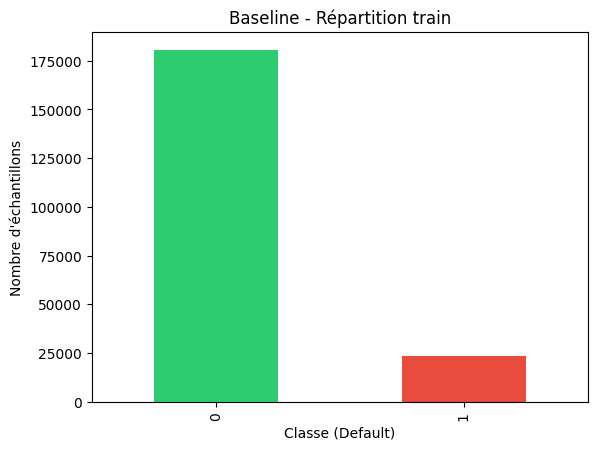

In [10]:
import matplotlib.pyplot as plt

def plot_dist(y, title):
    ax = y.value_counts().sort_index().plot(kind='bar', color=['#2ecc71','#e74c3c'])
    plt.title(title)
    plt.xlabel('Classe (Default)')
    plt.ylabel('Nombre d\'échantillons')
    plt.show()

plot_dist(y_train, "Baseline - Répartition train")


Sur-échantillonnage (SMOTE)


=== OPTION 1 : SMOTE ===

📊 Résultats pour Decision Tree avec SMOTE
              precision    recall  f1-score   support

           0      0.930     0.641     0.759     45139
           1      0.188     0.633     0.290      5931

    accuracy                          0.640     51070
   macro avg      0.559     0.637     0.524     51070
weighted avg      0.844     0.640     0.704     51070

🔹 Recall: 0.633
🔹 F1-Score: 0.290
🔹 AUC-ROC: 0.678


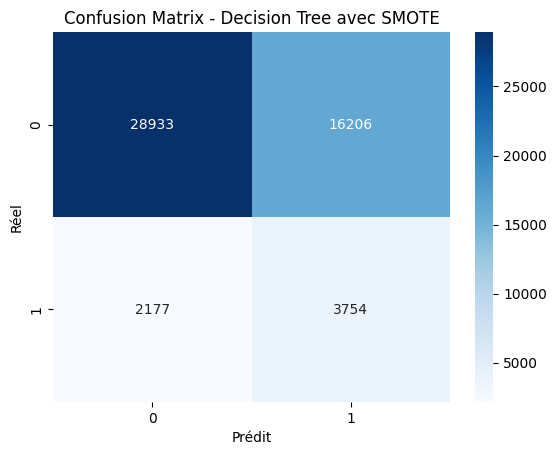

In [11]:
print("\n=== OPTION 1 : SMOTE ===")
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

dt_smote = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_smote.fit(X_train_sm, y_train_sm)
y_pred_sm = dt_smote.predict(X_test)
y_proba_sm = dt_smote.predict_proba(X_test)[:, 1]

rec_sm, f1_sm, auc_sm = evaluate_model(y_test, y_pred_sm, y_proba_sm, "Decision Tree avec SMOTE")

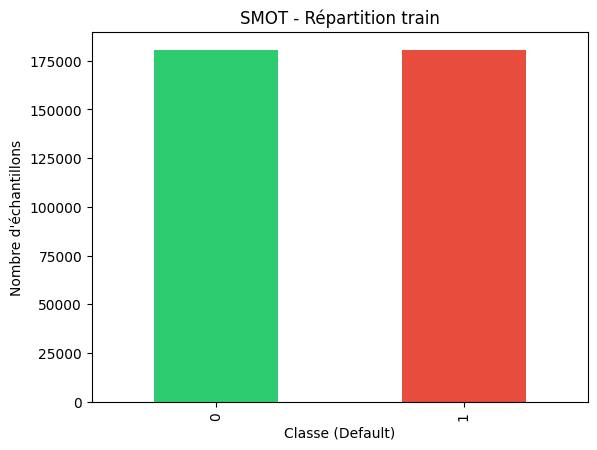

In [12]:
plot_dist(y_train_sm, "SMOT - Répartition train")

Sous Echantillage


=== OPTION 2 : Sous-échantillonnage ===

📊 Résultats pour Decision Tree avec Sous-échantillonnage
              precision    recall  f1-score   support

           0      0.940     0.676     0.786     45139
           1      0.214     0.669     0.324      5931

    accuracy                          0.675     51070
   macro avg      0.577     0.673     0.555     51070
weighted avg      0.855     0.675     0.733     51070

🔹 Recall: 0.669
🔹 F1-Score: 0.324
🔹 AUC-ROC: 0.729


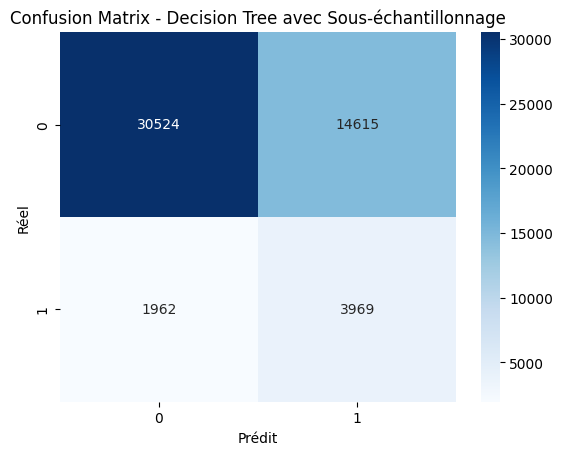

In [13]:
print("\n=== OPTION 2 : Sous-échantillonnage ===")
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

dt_rus = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = dt_rus.predict(X_test)
y_proba_rus = dt_rus.predict_proba(X_test)[:, 1]

rec_rus, f1_rus, auc_rus = evaluate_model(y_test, y_pred_rus, y_proba_rus, "Decision Tree avec Sous-échantillonnage")


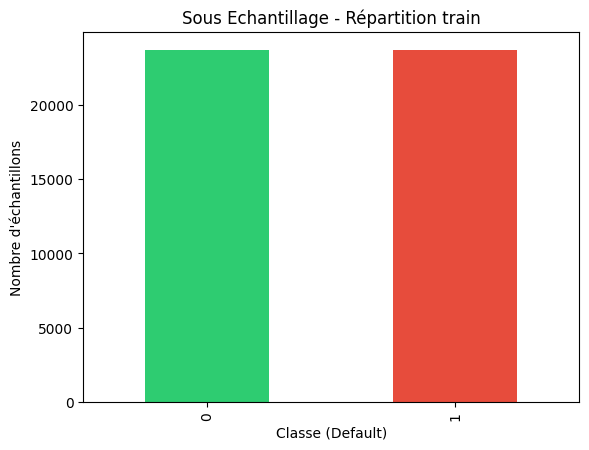

In [14]:
plot_dist(y_train_rus, "Sous Echantillage - Répartition train")

Pondération des classes


=== OPTION 3 : class_weight='balanced' ===

📊 Résultats pour Decision Tree avec Pondération des classes
              precision    recall  f1-score   support

           0      0.938     0.679     0.788     45139
           1      0.212     0.656     0.320      5931

    accuracy                          0.677     51070
   macro avg      0.575     0.668     0.554     51070
weighted avg      0.853     0.677     0.734     51070

🔹 Recall: 0.656
🔹 F1-Score: 0.320
🔹 AUC-ROC: 0.729


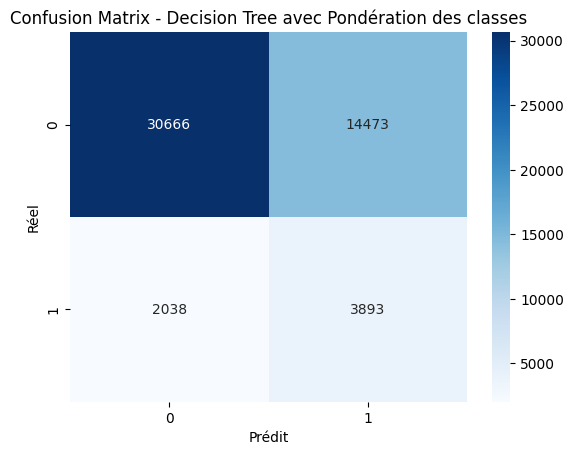

In [15]:
print("\n=== OPTION 3 : class_weight='balanced' ===")
dt_bal = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)
dt_bal.fit(X_train, y_train)
y_pred_bal = dt_bal.predict(X_test)
y_proba_bal = dt_bal.predict_proba(X_test)[:, 1]

rec_bal, f1_bal, auc_bal = evaluate_model(y_test, y_pred_bal, y_proba_bal, "Decision Tree avec Pondération des classes")


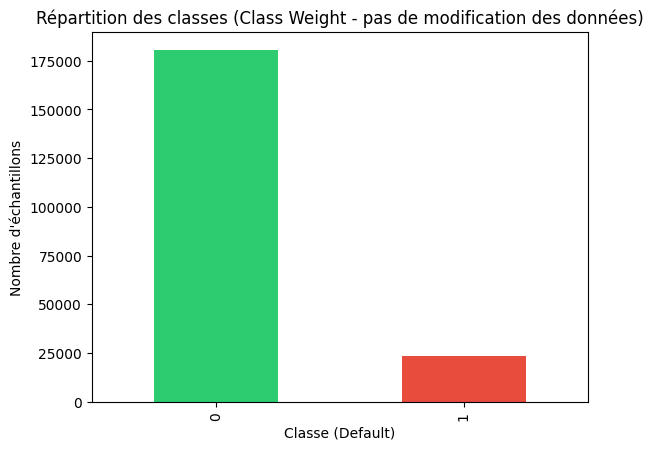

In [16]:
plot_dist(y_train, "Répartition des classes (Class Weight - pas de modification des données)")


Importation du best model

In [17]:
import joblib

In [18]:
# Sauvegarde du modèle Decision Tree sous-échantillonné
joblib.dump(dt_rus, '../Models/Decision_tree_best_model.pkl')
print("✅ Modèle enregistré dans ../Models/Decision_tree_best_model.pkl")

✅ Modèle enregistré dans ../Models/Decision_tree_best_model.pkl
